# Testing function for whitening code.
### Note that this must be run from the root repository directory.

In [1]:
%env CUDA_VISIBLE_DEVICES=1
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import os
import numpy as np
import tensorflow as tf
import data.data_selector as ds
import utils.plot_functions as pf
import utils.data_processing as dp
import matplotlib.pyplot as plt

In [3]:
params = {
  "data_type": "vanHateren",
  "num_images": 4,
  "extract_patches": False,
  "patch_edge_size": 16,
  "overlapping_patches": False,
  "randomize_patches": False,
  "patch_variance_threshold": 0,
  "norm_data": False,
  "whiten_data": False,
  "contrast_normalize": False,
  "data_dir": os.path.expanduser("~")+"/Work/Datasets/"}

In [4]:
data = ds.get_data(params)

In [5]:
full_img = dp.reshape_data(data["train"].images, flatten=False)[0]
patches_per_image = int((512/params["patch_edge_size"])**2)
patch_shape = (int(params["num_images"]*patches_per_image), int(params["patch_edge_size"]**2))
img_patches = dp.extract_patches(full_img, patch_shape, overlapping=params["overlapping_patches"], 
  randomize=params["randomize_patches"], var_thresh=params["patch_variance_threshold"])
recon_full_img = dp.patches_to_image(img_patches, params["num_images"], im_edge_size=512)

In [6]:
test_img = full_img[0,...]
test_patches = dp.extract_patches_from_single_image(test_img, 16)
recon_test_img = dp.patches_to_image(test_patches, 1, 512)
assert np.max(np.abs(test_img - recon_test_img)) == 0.0

In [7]:
ft_wht_data = dp.whiten_data(full_img, method="FT")[0]
pca_wht_patches = dp.whiten_data(img_patches, method="PCA")[0]
pca_wht_data = dp.patches_to_image(pca_wht_patches, num_im=params["num_images"], im_edge_size=512)
zca_wht_patches = dp.whiten_data(img_patches, method="ZCA")[0]
zca_wht_data = dp.patches_to_image(zca_wht_patches, num_im=params["num_images"], im_edge_size=512)

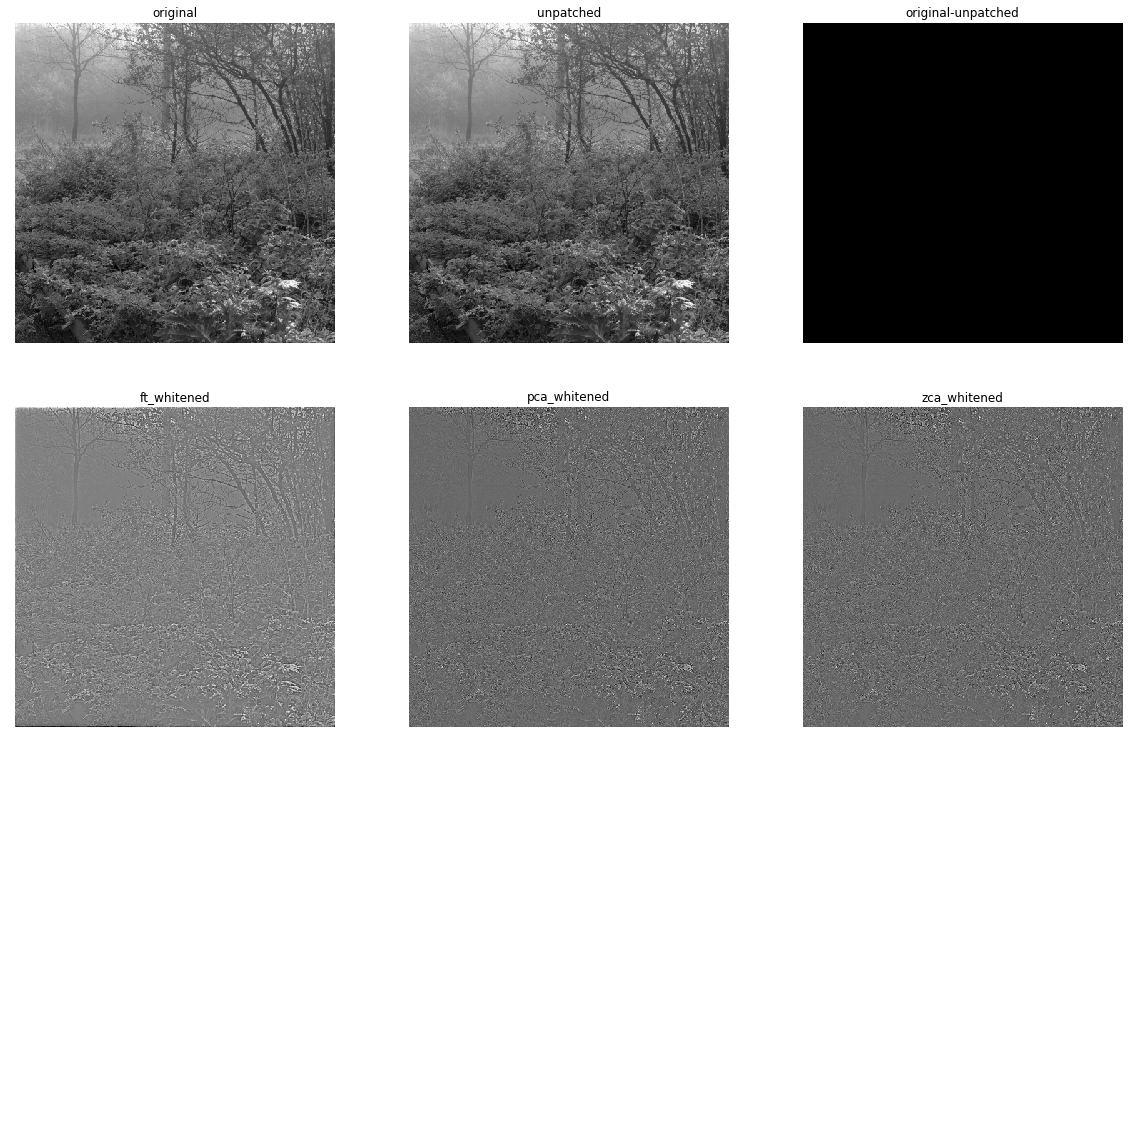

In [8]:
data_set = [full_img, recon_full_img, full_img-recon_full_img, ft_wht_data, pca_wht_data, zca_wht_data]
data_keys = ["original", "unpatched", "original-unpatched", "ft_whitened", "pca_whitened", "zca_whitened"]
img_idx = np.random.choice(params["num_images"], 1)[0]
num_plots_y = int(np.ceil(np.sqrt(len(data_set))))
num_plots_x = int(np.floor(np.sqrt(len(data_set)))+1)
fig, ax = plt.subplots(num_plots_y, num_plots_x, figsize=(20, 20))
img_count = 0
for plot_id in  np.ndindex((num_plots_y, num_plots_x)):
  ax[plot_id] = pf.clear_axis(ax[plot_id])
  if img_count < len(data_set):
    ax[plot_id].imshow(data_set[img_count][img_idx,...], cmap="Greys_r")
    ax[plot_id].set_title(data_keys[img_count])
  img_count += 1
plt.show()

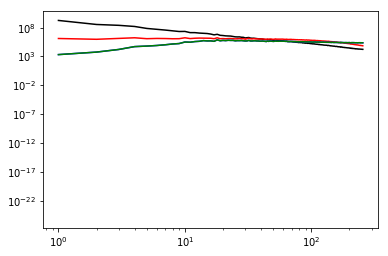

In [9]:
pspec = dp.phase_avg_pow_spec(full_img)
avg_pspec = np.mean(pspec, axis=0)

ft_pspec = dp.phase_avg_pow_spec(ft_wht_data)
avg_ft_pspec = np.mean(ft_pspec, axis=0)

pca_pspec = dp.phase_avg_pow_spec(pca_wht_data)
avg_pca_pspec = np.mean(pca_pspec, axis=0)

zca_pspec = dp.phase_avg_pow_spec(zca_wht_data)
avg_zca_pspec = np.mean(zca_pspec, axis=0)

(fig, ax) = plt.subplots(1)
ax.loglog(range(avg_pspec.shape[0]), avg_pspec, 'k')
ax.loglog(range(avg_ft_pspec.shape[0]), avg_ft_pspec, 'r')
ax.loglog(range(avg_pca_pspec.shape[0]), avg_pca_pspec, 'b')
ax.loglog(range(avg_zca_pspec.shape[0]), avg_zca_pspec, 'g') # should be the same as PCA
plt.show()